# Data Wrangling & Cleaning

## Goals
- Inspect and summarize data quality issues  
- Handle missing values (drop, fill, interpolate)  
- Detect and handle outliers (IQR and z-score methods)  
- Convert and enforce data types safely  
- Perform common string operations for cleaning text columns  
- Provide a short mini-project to apply these skills


In [15]:
# Environment check (run in Colab)
import sys
import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats

print("Python:", sys.version.split()[0])
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("scipy:", scipy.__version__)


Python: 3.13.5
pandas: 2.2.3
numpy: 2.1.3
scipy: 1.15.3


## 1 — Create a sample messy DataFrame
This dataset includes missing values, type inconsistencies, numeric outliers, and dirty string columns.


In [16]:
import pandas as pd
import numpy as np

np.random.seed(42)

data = {
    "id": range(1, 21),
    "age": [25, 30, None, 22, 120, 28, 27, None, 35, 29, 31, 27, 26, 24, None, 33, 40, -1, 29, 28],
    "income": [50000, 62000, 58000, None, 1_000_000, 54000, 52000, 51000, 60000, 59000,
               "65000", "not available", 48000, 47000, 45000, 70000, 72000, 68000, 66000, None],
    "join_date": ["2021-01-15", "2020/12/01", "15-02-2021", None, "2025-01-01",
                  "2021-06-03", "2021-07-15", "2021-07-20", "2021-08-01", "2021-09-10",
                  "2021-10-05", "2021-11-11", "2021-12-01", "2022-01-02", "2022-02-03", None, "2020-05-05", "2019-03-03", "2021-04-04", "2021-05-05"],
    "email": ["ALICE@example.COM", "bob@Example.com", " carol@example.com ", "dave@example", None,
              "emma@example.com", "frank@example.COM", "grace@Example.COM", "heidi@ex.com", "ivan@example.com",
              "judy@example.com", "kate@example.com", "leo@example.com", "mia@example.com", "nick@example.com",
              "oliver@example.com", "pam@example.com", "quinn@example.com", "ruth@example.com", "sam@example.com"],
    "notes": ["good", "", "n/a", None, "VIP customer", "follow up", "NA", "NA", "ok", "ok", "ok", "n/a", "", "good", None, "", "good", "ok", "n/a", "follow up"]
}

df = pd.DataFrame(data)
df.head(10)


,id,age,income,join_date,email,notes
0,1,25.0,50000,2021-01-15,ALICE@example.COM,good
1,2,30.0,62000,2020/12/01,bob@Example.com,
2,3,NaN,58000,15-02-2021,carol@example.com,n/a
3,4,22.0,None,None,dave@example,None
4,5,120.0,1000000,2025-01-01,None,VIP customer
5,6,28.0,54000,2021-06-03,emma@example.com,follow up
6,7,27.0,52000,2021-07-15,frank@example.COM,NA
7,8,NaN,51000,2021-07-20,grace@Example.COM,NA
8,9,35.0,60000,2021-08-01,heidi@ex.com,ok
9,10,29.0,59000,2021-09-10,ivan@example.com,ok


## 2 — Quick inspection and summaries
Use `.info()`, `.describe()`, missing-value counts, and unique value checks.


In [17]:
# size of the dataframe
df.shape

(20, 6)

In [18]:
# info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         20 non-null     int64  
 1   age        17 non-null     float64
 2   income     18 non-null     object 
 3   join_date  18 non-null     object 
 4   email      19 non-null     object 
 5   notes      18 non-null     object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.1+ KB


In [19]:
# describe
df.describe()

,id,age
count,20.00000,17.000000
mean,10.50000,32.529412
std,5.91608,24.052333
min,1.00000,-1.000000
25%,5.75000,26.000000
50%,10.50000,28.000000
75%,15.25000,31.000000
max,20.00000,120.000000


In [20]:
# describe on our object columns
df.describe(include='object')

,income,join_date,email,notes
count,18,18,19,18
unique,18,18,19,7
top,50000,2021-01-15,ALICE@example.COM,ok
freq,1,1,1,4


In [21]:
# check for null values
df.isnull().sum()

id           0
age          3
income       2
join_date    2
email        1
notes        2
dtype: int64

In [22]:
# percent of null values per column
df.isnull().sum() / df.shape[0]

id           0.00
age          0.15
income       0.10
join_date    0.10
email        0.05
notes        0.10
dtype: float64

In [23]:
# look at null values for age
df[df['age'].isnull()]

,id,age,income,join_date,email,notes
2,3,NaN,58000,15-02-2021,carol@example.com,n/a
7,8,NaN,51000,2021-07-20,grace@Example.COM,NA
14,15,NaN,45000,2022-02-03,nick@example.com,None


In [24]:
df.dropna().shape

(13, 6)

In [25]:
for x in df.columns:
    print(x)
    print(df[x].value_counts())
    print('---------' * 10)

id
id
1     1
2     1
19    1
18    1
17    1
16    1
15    1
14    1
13    1
12    1
11    1
10    1
9     1
8     1
7     1
6     1
5     1
4     1
3     1
20    1
Name: count, dtype: int64
------------------------------------------------------------------------------------------
age
age
 28.0     2
 27.0     2
 29.0     2
 25.0     1
 30.0     1
 22.0     1
 120.0    1
 35.0     1
 31.0     1
 26.0     1
 24.0     1
 33.0     1
 40.0     1
-1.0      1
Name: count, dtype: int64
------------------------------------------------------------------------------------------
income
income
50000            1
62000            1
68000            1
72000            1
70000            1
45000            1
47000            1
48000            1
not available    1
65000            1
59000            1
60000            1
51000            1
52000            1
54000            1
1000000          1
58000            1
66000            1
Name: count, dtype: int64
------------------------------------------

In [26]:
df['age'].dtypes

dtype('float64')

In [27]:
df['age'].unique()

array([ 25.,  30.,  nan,  22., 120.,  28.,  27.,  35.,  29.,  31.,  26.,
        24.,  33.,  40.,  -1.])

In [28]:
df['age'].astype(int)

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [ ]:
df.dtypes

,0
id,int64
age,float64
income,object
join_date,object
email,object
notes,object


In [ ]:
df[df['age'].isnull()]

,id,age,income,join_date,email,notes
2,3,NaN,58000,15-02-2021,carol@example.com,n/a
7,8,NaN,51000,2021-07-20,grace@Example.COM,NA
14,15,NaN,45000,2022-02-03,nick@example.com,None


In [ ]:
df.dtypes

,0
id,int64
age,float64
income,object
join_date,object
email,object
notes,object


In [ ]:
df['age'].describe()

,age
count,17.000000
mean,32.529412
std,24.052333
min,-1.000000
25%,26.000000
50%,28.000000
75%,31.000000
max,120.000000


In [ ]:
df.describe(include='all')

,id,age,income,join_date,email,notes
count,20.00000,17.000000,18.0,18,19,18
unique,NaN,NaN,18.0,18,19,7
top,NaN,NaN,50000.0,2021-01-15,ALICE@example.COM,ok
freq,NaN,NaN,1.0,1,1,4
mean,10.50000,32.529412,NaN,NaN,NaN,NaN
std,5.91608,24.052333,NaN,NaN,NaN,NaN
min,1.00000,-1.000000,NaN,NaN,NaN,NaN
25%,5.75000,26.000000,NaN,NaN,NaN,NaN
50%,10.50000,28.000000,NaN,NaN,NaN,NaN
75%,15.25000,31.000000,NaN,NaN,NaN,NaN


In [ ]:
df.shape[0]

20

In [ ]:
 df.isnull().sum()

,0
id,0
age,3
income,2
join_date,2
email,1
notes,2


In [ ]:
df.loc[3]

,3
id,4
age,22.0
income,None
join_date,None
email,dave@example
notes,None


<Axes: >

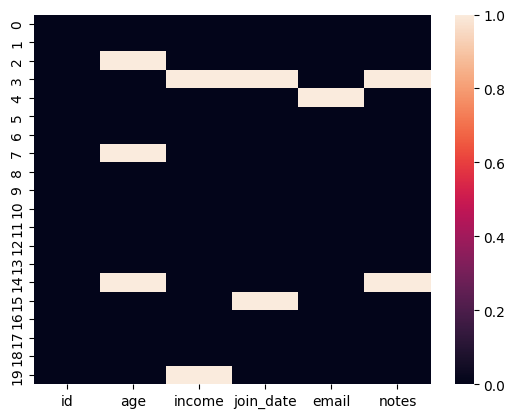

In [ ]:
 import seaborn as sns

 sns.heatmap(df.isnull())

In [ ]:
 df.isnull().sum() / df.shape[0]

,0
id,0.00
age,0.15
income,0.10
join_date,0.10
email,0.05
notes,0.10


In [ ]:
df['age'].unique()

array([ 25.,  30.,  nan,  22., 120.,  28.,  27.,  35.,  29.,  31.,  26.,
        24.,  33.,  40.,  -1.])

## 3 — Standardize and coerce data types safely
- Convert income to numeric (coerce errors to NaN)  
- Parse join_date to datetime with multiple formats  
- Clean whitespace in strings



In [ ]:
df['income'].unique()

array([50000, 62000, 58000, None, 1000000, 54000, 52000, 51000, 60000,
       59000, '65000', 'not available', 48000, 47000, 45000, 70000, 72000,
       68000, 66000], dtype=object)

In [ ]:
# df[df['income'] == 'not available'].loc[11, 'income'] = pd.NA # did not run

'not available'

In [ ]:
# Convert income to numeric (coerce errors to NaN)
# make a copy of the income column and name it income_raw
df['income_raw'] = df['income'].copy()
# convert to be numeric and non-numeric fields convert to null
df['income'] = pd.to_numeric(df['income_raw'], errors='coerce')

In [ ]:
# Parse join_date to datetime with multiple formats

# make a copy of the join date
df['join_date_raw'] = df['join_date'].copy()

# convert to datetime using format = mixed
df['join_date_mixed'] = pd.to_datetime(df['join_date'], format='mixed')

# convert to datetime using error = coerce
df['join_date_coerce'] = pd.to_datetime(df['join_date'], errors='coerce',
                                        format='%Y-%m-%d')

df[['join_date_raw', 'join_date_mixed', 'join_date_coerce']]

,join_date_raw,join_date_mixed,join_date_coerce
0,2021-01-15,2021-01-15,2021-01-15
1,2020/12/01,2020-12-01,NaT
2,15-02-2021,2021-02-15,NaT
3,None,NaT,NaT
4,2025-01-01,2025-01-01,2025-01-01
5,2021-06-03,2021-06-03,2021-06-03
6,2021-07-15,2021-07-15,2021-07-15
7,2021-07-20,2021-07-20,2021-07-20
8,2021-08-01,2021-08-01,2021-08-01
9,2021-09-10,2021-09-10,2021-09-10


In [ ]:
df['day_of_week'] = df['join_date_mixed'].dt.day_name()
df.head()

,id,age,income,join_date,email,notes,income_raw,join_date_raw,join_date_mixed,join_date_coerce,day_of_week
0,1,25.0,50000.0,2021-01-15,ALICE@example.COM,good,50000,2021-01-15,2021-01-15,2021-01-15,Friday
1,2,30.0,62000.0,2020/12/01,bob@Example.com,,62000,2020/12/01,2020-12-01,NaT,Tuesday
2,3,NaN,58000.0,15-02-2021,carol@example.com,n/a,58000,15-02-2021,2021-02-15,NaT,Monday
3,4,22.0,NaN,None,dave@example,None,None,None,NaT,NaT,NaN
4,5,120.0,1000000.0,2025-01-01,None,VIP customer,1000000,2025-01-01,2025-01-01,2025-01-01,Wednesday


In [ ]:
# Clean whitespace in strings
df['email'].unique()

array(['ALICE@example.COM', 'bob@Example.com', ' carol@example.com ',
       'dave@example', None, 'emma@example.com', 'frank@example.COM',
       'grace@Example.COM', 'heidi@ex.com', 'ivan@example.com',
       'judy@example.com', 'kate@example.com', 'leo@example.com',
       'mia@example.com', 'nick@example.com', 'oliver@example.com',
       'pam@example.com', 'quinn@example.com', 'ruth@example.com',
       'sam@example.com'], dtype=object)

In [ ]:
df[df['email'] == 'carol@example.com']

,id,age,income,join_date,email,notes,income_raw,join_date_raw,join_date_mixed,join_date_coerce,day_of_week


In [ ]:
df[df['email'] == ' carol@example.com ']

,id,age,income,join_date,email,notes,income_raw,join_date_raw,join_date_mixed,join_date_coerce,day_of_week
2,3,NaN,58000.0,15-02-2021,carol@example.com,n/a,58000,15-02-2021,2021-02-15,NaT,Monday


In [ ]:
# make raw column
df['email_raw'] = df['email'].copy()

df['email'] = df['email'].str.strip().str.lower()

In [ ]:
df['email'].str.strip().str.lower().head(2)

,email
0,alice@example.com
1,bob@example.com


In [ ]:
df[df['email'] == 'carol@example.com']

,id,age,income,join_date,email,notes,income_raw,join_date_raw,join_date_mixed,join_date_coerce,day_of_week,email_raw
2,3,NaN,58000.0,15-02-2021,carol@example.com,n/a,58000,15-02-2021,2021-02-15,NaT,Monday,carol@example.com


In [ ]:
# clean notes column

df['notes'].head()

,notes
0,good
1,
2,n/a
3,None
4,VIP customer


In [ ]:
df['notes'].isnull().head()

,notes
0,False
1,False
2,False
3,True
4,False


In [ ]:
# remove whiteshpace from notes column
# and standardizes Null values

df['notes'] = df['notes'].str.strip().replace({'': pd.NA, 'n/a': pd.NA, 'NA': pd.NA})

In [ ]:
df['notes'].isnull().sum()

np.int64(10)

In [ ]:
df.head(2)

,id,age,income,join_date,email,notes,income_raw,join_date_raw,join_date_mixed,join_date_coerce,day_of_week,email_raw
0,1,25.0,50000.0,2021-01-15,alice@example.com,good,50000,2021-01-15,2021-01-15,2021-01-15,Friday,ALICE@example.COM
1,2,30.0,62000.0,2020/12/01,bob@example.com,<NA>,62000,2020/12/01,2020-12-01,NaT,Tuesday,bob@Example.com


In [ ]:
df['notes'].head()

,notes
0,good
1,<NA>
2,<NA>
3,None
4,VIP customer


In [ ]:
df['notes'].isnull().head()

,notes
0,False
1,True
2,True
3,True
4,False


## 4 — Handling missing values
Common strategies: drop, fill with constant, fill with aggregate (mean/median/mode), forward/backward fill, interpolation.

Choose strategy by column semantics.


In [ ]:
df.isnull().sum()

,0
id,0
age,3
income,3
join_date,2
email,1
notes,10
income_raw,2
join_date_raw,2
join_date_mixed,2
join_date_coerce,4


In [ ]:
# age
df.corr(numeric_only=True)

,id,age,income
id,1.000000,-0.263339,-0.221308
age,-0.263339,1.000000,0.938018
income,-0.221308,0.938018,1.000000


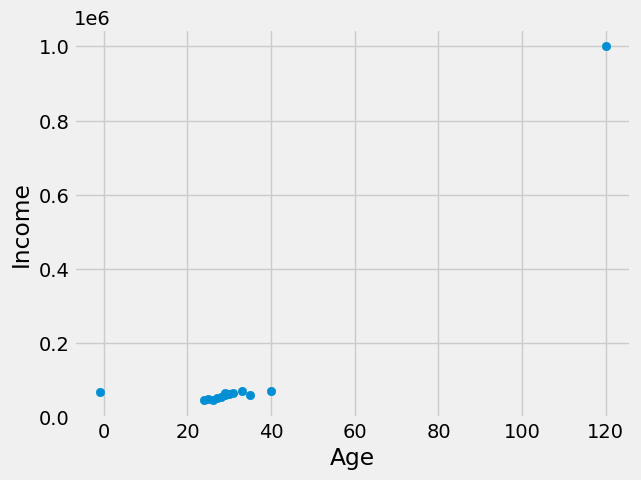

In [ ]:
import matplotlib.pyplot as plt
with plt.style.context('fivethirtyeight'):
  plt.scatter(df['age'], df['income'])
  plt.xlabel('Age')
  plt.ylabel('Income')


In [ ]:
# look at age > 100
df[df['age'] > 100]

,id,age,income,join_date,email,notes,income_raw,join_date_raw,join_date_mixed,join_date_coerce,day_of_week,email_raw
4,5,120.0,1000000.0,2025-01-01,None,VIP customer,1000000,2025-01-01,2025-01-01,2025-01-01,Wednesday,None


In [ ]:
# look at age < 0
df[df['age'] < 0]

,id,age,income,join_date,email,notes,income_raw,join_date_raw,join_date_mixed,join_date_coerce,day_of_week,email_raw
17,18,-1.0,68000.0,2019-03-03,quinn@example.com,ok,68000,2019-03-03,2019-03-03,2019-03-03,Sunday,quinn@example.com


In [ ]:
df_no_age_outlier = df[(df['age'] > 0) & (df['age'] < 100)]
df_no_age_outlier.corr(numeric_only=True)

,id,age,income
id,1.000000,0.357529,0.451496
age,0.357529,1.000000,0.839840
income,0.451496,0.839840,1.000000


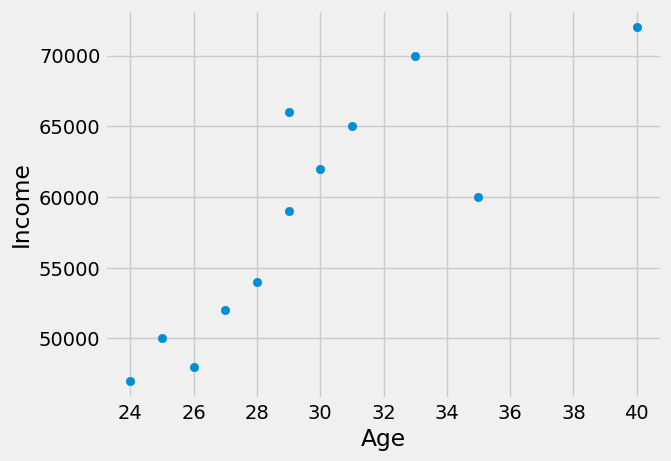

In [ ]:
with plt.style.context('fivethirtyeight'):
  plt.scatter(df_no_age_outlier['age'], df_no_age_outlier['income'])
  plt.xlabel('Age')
  plt.ylabel('Income')

In [ ]:
df['age'].describe()

,age
count,17.000000
mean,32.529412
std,24.052333
min,-1.000000
25%,26.000000
50%,28.000000
75%,31.000000
max,120.000000


In [ ]:
df['age_filled_median'] = df['age'].fillna(df['age'].median())
df[['age_filled_median', 'age']].describe()

,age_filled_median,age
count,20.00000,17.000000
mean,31.85000,32.529412
std,22.13422,24.052333
min,-1.00000,-1.000000
25%,26.75000,26.000000
50%,28.00000,28.000000
75%,30.25000,31.000000
max,120.00000,120.000000


In [ ]:
# fill missing values of income

df['income'].describe()

,income
count,17.000000
mean,113352.941176
std,228638.071298
min,45000.000000
25%,51000.000000
50%,59000.000000
75%,66000.000000
max,1000000.000000


<Axes: xlabel='income', ylabel='Count'>

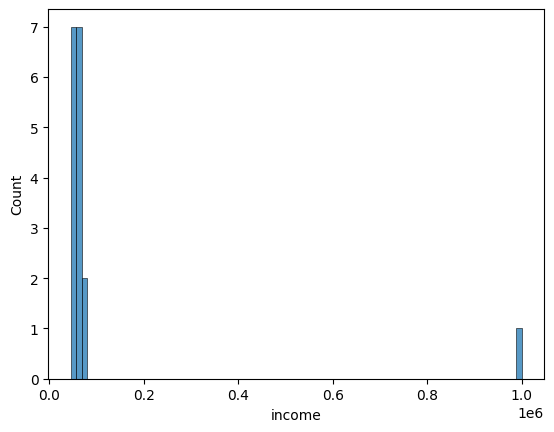

In [ ]:
sns.histplot(df['income'])

In [ ]:
df['income_filled_median'] = df['income'].fillna(df['income'].median())
df[['income_filled_median', 'income']].describe()

,income_filled_median,income
count,20.00000,17.000000
mean,105200.00000,113352.941176
std,210755.43322,228638.071298
min,45000.00000,45000.000000
25%,51750.00000,51000.000000
50%,59000.00000,59000.000000
75%,65250.00000,66000.000000
max,1000000.00000,1000000.000000


In [ ]:
# join_date
df[['join_date_raw', 'join_date_mixed', 'join_date_coerce', 'join_date']].head()

,join_date_raw,join_date_mixed,join_date_coerce,join_date
0,2021-01-15,2021-01-15,2021-01-15,2021-01-15
1,2020/12/01,2020-12-01,NaT,2020/12/01
2,15-02-2021,2021-02-15,NaT,15-02-2021
3,None,NaT,NaT,None
4,2025-01-01,2025-01-01,2025-01-01,2025-01-01


In [ ]:
df[df['join_date'].isnull()]

,id,age,income,join_date,email,notes,income_raw,join_date_raw,join_date_mixed,join_date_coerce,day_of_week,email_raw,age_filled_median,income_filled_median
3,4,22.0,NaN,None,dave@example,None,None,None,NaT,NaT,NaN,dave@example,22.0,59000.0
15,16,33.0,70000.0,None,oliver@example.com,<NA>,70000,None,NaT,NaT,NaN,oliver@example.com,33.0,70000.0


In [ ]:
df['day_of_week'].value_counts()

,count
day_of_week,
Tuesday,4
Sunday,4
Thursday,4
Wednesday,3
Friday,2
Monday,1


In [ ]:
df[df['email'].isnull()]

,id,age,income,join_date,email,notes,income_raw,join_date_raw,join_date_mixed,join_date_coerce,day_of_week,email_raw,age_filled_median,income_filled_median
4,5,120.0,1000000.0,2025-01-01,None,VIP customer,1000000,2025-01-01,2025-01-01,2025-01-01,Wednesday,None,120.0,1000000.0


In [ ]:
import numpy as np

df['email_flag'] = np.where(df['email'].isnull(), 0, 1)
df[['email', 'email_flag']].head()

,email,email_flag
0,alice@example.com,1
1,bob@example.com,1
2,carol@example.com,1
3,dave@example,1
4,None,0


In [ ]:
df.isnull().sum()

,0
id,0
age,3
income,3
join_date,2
email,1
notes,10
income_raw,2
join_date_raw,2
join_date_mixed,2
join_date_coerce,4


## 5 — Detecting outliers
Two common approaches: IQR method and z-score. Use domain knowledge to decide treatment.


In [ ]:
q1 = df['age'].quantile(0.25)
q3 = df['age'].quantile(0.75)

iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print(lower_bound, upper_bound)

18.5 38.5


In [ ]:
df[(df['age'] < lower_bound) | (df['age'] > upper_bound)]

,id,age,income,join_date,email,notes,income_raw,join_date_raw,join_date_mixed,join_date_coerce,day_of_week,email_raw,age_filled_median,income_filled_median,email_flag
4,5,120.0,1000000.0,2025-01-01,None,VIP customer,1000000,2025-01-01,2025-01-01,2025-01-01,Wednesday,None,120.0,1000000.0,0
16,17,40.0,72000.0,2020-05-05,pam@example.com,good,72000,2020-05-05,2020-05-05,2020-05-05,Tuesday,pam@example.com,40.0,72000.0,1
17,18,-1.0,68000.0,2019-03-03,quinn@example.com,ok,68000,2019-03-03,2019-03-03,2019-03-03,Sunday,quinn@example.com,-1.0,68000.0,1


In [ ]:
q1_income = df['income'].quantile(0.25)
q3_income = df['income'].quantile(0.75)

iqr_income = q3_income - q1_income

lower_bound_income = q1_income - 1.5 * iqr_income
upper_bound_income = q3_income + 1.5 * iqr_income

print(lower_bound_income, upper_bound_income)

28500.0 88500.0


In [ ]:
df[(df['income'] < lower_bound_income) | (df['income'] > upper_bound_income)]

,id,age,income,join_date,email,notes,income_raw,join_date_raw,join_date_mixed,join_date_coerce,day_of_week,email_raw,age_filled_median,income_filled_median,email_flag
4,5,120.0,1000000.0,2025-01-01,None,VIP customer,1000000,2025-01-01,2025-01-01,2025-01-01,Wednesday,None,120.0,1000000.0,0


In [ ]:
# z score for age
df['age_zscore'] = (df['age'] - df['age'].mean()) / df['age'].std()
df[(df['age_zscore'] < -3) | (df['age_zscore'] > 3)]

,id,age,income,join_date,email,notes,income_raw,join_date_raw,join_date_mixed,join_date_coerce,day_of_week,email_raw,age_filled_median,income_filled_median,email_flag,age_zscore
4,5,120.0,1000000.0,2025-01-01,None,VIP customer,1000000,2025-01-01,2025-01-01,2025-01-01,Wednesday,None,120.0,1000000.0,0,3.636678


In [ ]:
# z score for income
df['income_zscore'] = (df['income'] - df['income'].mean()) / df['income'].std()
df[(df['income_zscore'] < -3) | (df['income_zscore'] > 3)]

,id,age,income,join_date,email,notes,income_raw,join_date_raw,join_date_mixed,join_date_coerce,day_of_week,email_raw,age_filled_median,income_filled_median,email_flag,age_zscore,income_zscore
4,5,120.0,1000000.0,2025-01-01,None,VIP customer,1000000,2025-01-01,2025-01-01,2025-01-01,Wednesday,None,120.0,1000000.0,0,3.636678,3.87795


## 6 — Handling outliers
Options: remove, winsorize, cap to percentiles, transform (log), or treat as missing then impute.


In [ ]:
df['age'].quantile(0.05), df['age'].quantile(0.95)

(np.float64(17.400000000000002), np.float64(55.99999999999994))

In [ ]:
df.head()

,id,age,income,join_date,email,notes,income_raw,join_date_raw,join_date_mixed,join_date_coerce,day_of_week,email_raw,age_filled_median,income_filled_median,email_flag,age_zscore,income_zscore,age_clipped,income_clipped
0,1,25.0,50000.0,2021-01-15,alice@example.com,good,50000,2021-01-15,2021-01-15,2021-01-15,Friday,ALICE@example.COM,25.0,50000.0,1,-0.313043,-0.277088,25.0,50000.0
1,2,30.0,62000.0,2020/12/01,bob@example.com,<NA>,62000,2020/12/01,2020-12-01,NaT,Tuesday,bob@Example.com,30.0,62000.0,1,-0.105163,-0.224604,30.0,62000.0
2,3,NaN,58000.0,15-02-2021,carol@example.com,<NA>,58000,15-02-2021,2021-02-15,NaT,Monday,carol@example.com,28.0,58000.0,1,NaN,-0.242099,NaN,58000.0
3,4,22.0,NaN,None,dave@example,None,None,None,NaT,NaT,NaN,dave@example,22.0,59000.0,1,-0.437771,NaN,22.0,NaN
4,5,120.0,1000000.0,2025-01-01,None,VIP customer,1000000,2025-01-01,2025-01-01,2025-01-01,Wednesday,None,120.0,1000000.0,0,3.636678,3.877950,56.0,257600.0


In [ ]:
# clip age
df['age_clipped'] = df['age_filled_median'].clip(lower=df['age'].quantile(0.05),
                                   upper=df['age'].quantile(0.95))
df[['age', 'age_clipped']].describe()

,age,age_clipped
count,17.000000,20.000000
mean,32.529412,29.570000
std,24.052333,7.769922
min,-1.000000,17.400000
25%,26.000000,26.750000
50%,28.000000,28.000000
75%,31.000000,30.250000
max,120.000000,56.000000


In [ ]:
df['age_clipped'] = df['age_clipped'].round(0).astype(int)

In [ ]:
df['age_clipped'].dtypes

dtype('int64')

In [ ]:
df['income'].quantile(0.05), df['income'].quantile(0.95)

(np.float64(46600.0), np.float64(257599.99999999933))

In [ ]:
# clip income
df['income_clipped'] = df['income'].clip(lower=df['income'].quantile(0.05),
                                   upper=df['income'].quantile(0.95))
df[['income', 'income_clipped']].describe()

,income,income_clipped
count,17.000000,17.000000
mean,113352.941176,69776.470588
std,228638.071298,49099.688510
min,45000.000000,46600.000000
25%,51000.000000,51000.000000
50%,59000.000000,59000.000000
75%,66000.000000,66000.000000
max,1000000.000000,257600.000000


In [ ]:
df.drop(df[df['age'] > 100].index)

Index([4], dtype='int64')

## 7 — String operations & text cleaning
Common tasks: trim, lower/upper, remove punctuation, regex replacements, extract patterns (emails, domains).


In [ ]:
# Trim and normalize email domain extraction
df["email_clean"] = df["email"].str.strip().str.lower()
df["email_valid"] = df["email_clean"].str.contains(r"^[\w\.-]+@[\w\.-]+\.\w+$", na=False)
df["email_domain"] = df["email_clean"].str.extract(r"@([^@]+)$", expand=False)

# Clean notes by normalizing common tokens
df["notes_clean"] = df["notes"].str.lower().replace({pd.NA: None})
df["notes_clean"] = df["notes_clean"].fillna("").str.replace(r"[^a-z0-9\s]", "", regex=True).str.strip()
df[["id", "email", 'email_clean', "email_valid", "email_domain", "notes", "notes_clean"]]



,id,email,email_clean,email_valid,email_domain,notes,notes_clean
0,1,alice@example.com,alice@example.com,True,example.com,good,good
1,2,bob@example.com,bob@example.com,True,example.com,<NA>,
2,3,carol@example.com,carol@example.com,True,example.com,<NA>,
3,4,dave@example,dave@example,False,example,None,
4,5,None,None,False,None,VIP customer,vip customer
5,6,emma@example.com,emma@example.com,True,example.com,follow up,follow up
6,7,frank@example.com,frank@example.com,True,example.com,<NA>,
7,8,grace@example.com,grace@example.com,True,example.com,<NA>,
8,9,heidi@ex.com,heidi@ex.com,True,ex.com,ok,ok
9,10,ivan@example.com,ivan@example.com,True,example.com,ok,ok


## 8 — Build small, reusable cleaning functions
Wrap repeated logic in functions so you can apply the same pipeline to new datasets.


In [ ]:
def coerce_numeric_column(s: pd.Series, fill_null_with_median=False):
  """
  Takes a pandas series as an input
    - Converts to numeric and non-numeric fields convert to null
    - Optionally fills in missing values with the median
  """
  s = pd.to_numeric(s, errors='coerce')
  if fill_null_with_median:
    s = s.fillna(s.median())
  return s

def coerce_date_column(s: pd.Series, dayfirst=False, yearfirst=False,
                        format=None, fill_null_with_mode=False):
  """
  Takes a pandas series as an input
    - Converts to datetime and non-datetime fields convert to null
    - Optionally fills in missing values with the mode
  """
  s = pd.to_datetime(s, errors='coerce', dayfirst=dayfirst,
                     yearfirst=yearfirst, format=format)
  if fill_null_with_mode:
    s = s.fillna(s.mode()[0])
  return s

In [ ]:
coerce_date_column(df['join_date'], fill_null_with_mode=True)

,join_date
0,2021-01-15
1,2019-03-03
2,2019-03-03
3,2019-03-03
4,2025-01-01
5,2021-06-03
6,2021-07-15
7,2021-07-20
8,2021-08-01
9,2021-09-10


In [ ]:
df[[x for x in df.columns if 'income' in x.lower()]].dtypes

,0
income,float64
income_raw,object
income_filled_median,float64
income_zscore,float64
income_clipped,float64


In [ ]:
coerce_numeric_column(df['income_raw'], fill_null_with_median=True)

KeyError: 'income_raw'

In [ ]:
df

,id,age,income,join_date,email,notes
0,1,25.0,50000,2021-01-15,ALICE@example.COM,good
1,2,30.0,62000,2020/12/01,bob@Example.com,
2,3,NaN,58000,15-02-2021,carol@example.com,n/a
3,4,22.0,None,None,dave@example,None
4,5,120.0,1000000,2025-01-01,None,VIP customer
5,6,28.0,54000,2021-06-03,emma@example.com,follow up
6,7,27.0,52000,2021-07-15,frank@example.COM,NA
7,8,NaN,51000,2021-07-20,grace@Example.COM,NA
8,9,35.0,60000,2021-08-01,heidi@ex.com,ok
9,10,29.0,59000,2021-09-10,ivan@example.com,ok


## 9 — Mini-project (exercise)
1. Use the provided `df`.  
2. Create a cleaned version `df_clean` that:
   - Ensures `age` is numeric and reasonable (0 < age <= 110), fill missing with median.  
   - Coerces `income` to numeric and caps at 99th percentile.  
   - Parses `join_date` and keeps only year and month as `YYYY-MM` string.  
   - Keeps only rows with valid emails.  
3. Produce summary counts: rows before/after cleaning, number of imputed ages, number of capped incomes.


In [31]:
# Mini-project Solution
df_clean = df.copy()
rows_before = len(df_clean)

# age: numeric, 0-110, fill with median
df_clean['age'] = pd.to_numeric(df_clean['age'], errors='coerce')
df_clean.loc[(df_clean['age'] <= 0) | (df_clean['age'] > 110), 'age'] = np.nan
ages_to_impute = df_clean['age'].isna().sum()
age_median = df_clean['age'].median()
df_clean['age'] = df_clean['age'].fillna(age_median)

# income: numeric, cap at 99th percentile
df_clean['income'] = pd.to_numeric(df_clean['income'], errors='coerce')
p99 = df_clean['income'].quantile(0.99)
incomes_capped = (df_clean['income'] > p99).sum()
df_clean['income'] = df_clean['income'].clip(upper=p99)

# join_date: parse to YYYY-MM
df_clean['join_date_parsed'] = pd.to_datetime(df_clean['join_date'], errors='coerce', infer_datetime_format=True)
df_clean['join_ym'] = df_clean['join_date_parsed'].dt.to_period('M').astype(str).fillna('missing')

# email: keep only valid emails
df_clean['email_clean'] = df_clean['email'].str.strip().str.lower()
valid_mask = df_clean['email_clean'].str.match(r'^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$', na=False)
df_clean = df_clean[valid_mask].reset_index(drop=True)

rows_after = len(df_clean)
print(f"Before: {rows_before}, After (valid emails): {rows_after}")
print(f"Imputed ages: {ages_to_impute}, Income capped: {incomes_capped}, p99: ${p99:,.0f}")
df_clean[['id', 'age', 'income', 'join_ym', 'email_clean']].head(18)

Before: 20, After (valid emails): 18
Imputed ages: 5, Income capped: 1, p99: $851,520


/var/folders/4z/kp7dhv_100x6f98d2f4gzjzr0000gn/T/ipykernel_5036/43990825.py:19: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_clean['join_date_parsed'] = pd.to_datetime(df_clean['join_date'], errors='coerce', infer_datetime_format=True)


,id,age,income,join_ym,email_clean
0,1,25.0,50000.0,2021-01,alice@example.com
1,2,30.0,62000.0,NaT,bob@example.com
2,3,28.0,58000.0,NaT,carol@example.com
3,6,28.0,54000.0,2021-06,emma@example.com
4,7,27.0,52000.0,2021-07,frank@example.com
5,8,28.0,51000.0,2021-07,grace@example.com
6,9,35.0,60000.0,2021-08,heidi@ex.com
7,10,29.0,59000.0,2021-09,ivan@example.com
8,11,31.0,65000.0,2021-10,judy@example.com
9,12,27.0,NaN,2021-11,kate@example.com


In [ ]:
# Check data type of income column in cleaned dataframe
print("Income column data type:", df_clean['income'].dtype)
print("\nFirst 5 income values:")
print(df_clean['income'].head())

## 10 — Further exercises and suggestions
- Try different imputation strategies: mean vs median vs KNN imputation (sklearn).  
- Experiment with winsorizing vs log-transform for skewed distributions.  
- Build a small pipeline function that accepts a DataFrame and returns a cleaned DataFrame.  
- Version your cleaning steps in a notebook so transformations are reproducible.


<Axes: xlabel='income_clean', ylabel='Count'>

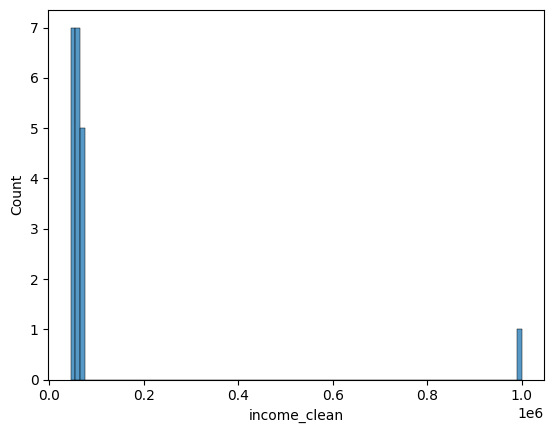

In [ ]:
df['income_clean'] = coerce_numeric_column(df['income'], fill_null_with_median=True)

sns.histplot(df['income_clean'])

<Axes: xlabel='income_clean', ylabel='Count'>

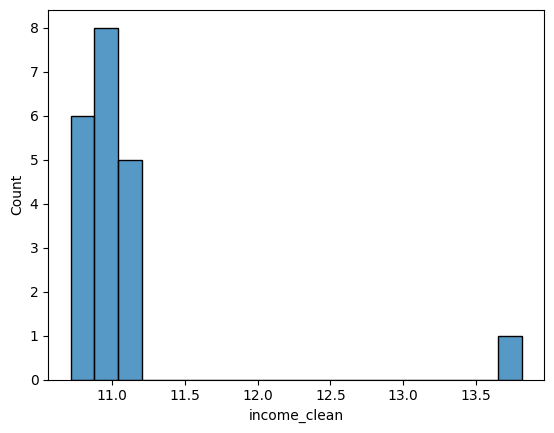

In [ ]:
sns.histplot(np.log(df['income_clean']))

In [ ]:
df['income_log'] = np.log(df['income_clean'])
df.head()

,id,age,income,join_date,email,notes,income_clean,income_log
0,1,25.0,50000,2021-01-15,ALICE@example.COM,good,50000.0,10.819778
1,2,30.0,62000,2020/12/01,bob@Example.com,,62000.0,11.034890
2,3,NaN,58000,15-02-2021,carol@example.com,n/a,58000.0,10.968198
3,4,22.0,None,None,dave@example,None,59000.0,10.985293
4,5,120.0,1000000,2025-01-01,None,VIP customer,1000000.0,13.815511
